In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

# Problem definition

In [22]:
NUMBERS = [2, 3, 5, 7, 10, 12, 15, 20, 23, 25, 30, 35, 40, 50, 60]
OPERATIONS = ["+", "-", "*", "/"]
TARGET = 567

def f2(operation):
  value = abs(operation.evaluate() - TARGET)
  # Apply a penalization if the operation has less than 8 numbers
  pen_term = 8 - len(operation.numbers)
  if pen_term > 0:
    value += 50 * pen_term

  # Apply a second penalization if the operation repeats numbers
  pen_term2 = (np.unique(operation.numbers, return_counts=True)[1] - 1).sum() # Number of repetitions
  value += 100 * pen_term2
  return value

def check_valid2(operation):
  return len(operation.numbers) >= 8 and np.all(np.unique(operation.numbers, return_counts=True)[1] == 1)

# Solution space

In [23]:
class Operation:
    def __init__(self, numbers, operations, order):
        self.numbers = numbers
        self.operations = operations
        self.order = order

    def __str__(self):
        return f"{self.numbers} {self.operations} {self.order}"

    def __repr__(self):
        return self.__str__()

    def evaluate(self):
      # Copy the numbers list to avoid modifying the original
      num_list = self.numbers[:]
      op_list = self.operations[:]
      order_list = self.order[:]

      for i in range(len(order_list)):

          op_index = order_list[i]

          num1 = num_list[op_index]
          num2 = num_list[op_index + 1]
          operation = op_list[op_index]

          if operation == '+':
              result = num1 + num2
          elif operation == '-':
              result = num1 - num2
          elif operation == '*':
              result = num1 * num2
          elif operation == '/':
              result = num1 / num2 if num2 != 0 else float('inf')

          # Replace the numbers in the list with the result of the operation
          num_list[op_index] = result
          num_list.pop(op_index + 1)  # Remove the second number

          # Remove the operation from the list
          op_list.pop(op_index)

          # Decrement all indices that are greater than op_index
          order_list = [i - 1 if i > op_index else i for i in order_list]

      # The result of the final evaluation is the only element left in num_list
      return num_list[0]

    def copy(self):
        return Operation(self.numbers.copy(), self.operations.copy(), self.order.copy())


In [24]:
example = Operation([4, 5, 6, 7], ['+', '-', '/'], [2, 0, 1])
print(example)
print(example.evaluate())

[4, 5, 6, 7] ['+', '-', '/'] [2, 0, 1]
8.142857142857142


# Mutations

In [25]:
from re import L
import random
def swap_random(l):
    i = random.randint(0, len(l) - 1)
    j = random.randint(0, len(l) - 1)
    l[i], l[j] = l[j], l[i]
    return l

# Create a new operation that has a different order of operations
def swap_order(operation):
    new_op = operation.copy()
    new_op.order = swap_random(new_op.order)
    return new_op

def swap_numbers(operation):
    new_op = operation.copy()
    new_op.numbers = swap_random(new_op.numbers)
    return new_op

def swap_operations(operation):
    new_op = operation.copy()
    new_op.operations = swap_random(new_op.operations)
    return new_op

def change_operation(operation):
    new_op = operation.copy()
    new_op.operations[random.randint(0, len(new_op.operations) - 1)] = random.choice(OPERATIONS)
    return new_op

def change_number(operation):
    if len(operation.numbers) >= len(NUMBERS):
        return operation
    new_op = operation.copy()
    try:
      new_op.numbers[random.randint(0, len(new_op.numbers) - 1)] = random.choice(list(set(NUMBERS)-set(new_op.numbers)))
    except:
      print(operation)
      raise
    return new_op

# We will only add and remove operations from the end of the list, since later they can swap.
# Maybe we can try later if allowing inserts and pops in random places improves.
def add_operation(operation):
    if len(operation.numbers) >= len(NUMBERS):
        return operation
    new_op = operation.copy()
    new_op.operations.append(random.choice(OPERATIONS)) # Add a new operation at the end
    new_op.order.append(len(new_op.operations) - 1) # Make that operation the lowest priority
    new_op.numbers.append(random.choice(list(set(NUMBERS)-set(new_op.numbers)))) # Add a new number at the end to operate with
    return new_op

def remove_operation(operation):
    new_op = operation.copy()
    new_op.order.remove(len(new_op.operations) - 1) # Remove the last operation from the order list
    new_op.operations = new_op.operations[:-1] # Remove the last operation
    new_op.numbers = new_op.numbers[:-1] # Remove the last number
    return new_op

In [26]:
add_operation(example)

[4, 5, 6, 7, 30] ['+', '-', '/', '*'] [2, 0, 1, 3]

# Simulated annealing

In [27]:
# Generate a random neighbour solution
def get_neighbour(operation):
  calls = [swap_order, swap_numbers, swap_operations, change_operation, change_number, add_operation, remove_operation]
  # TODO: we could make some calls more probable than others.
  return random.choice(calls)(operation)

In [28]:
import math
def simulated_anealing(x0, f, check_valid, T0=1000, alpha=0.99, max_iterations=1000, tol=0.01):
  # Log info
  X = [x0]
  V = [x0.evaluate()]
  F = [f(x0)]
  Tv = [T0]

  # Run SA
  x = x0
  T = T0
  best_x, best_f = x, f(x)

  stop_counter = 0
  for i in range(max_iterations):
    x_new = get_neighbour(x)
    f_new = f(x_new)
    delta_f = f_new - f(x)

    stop_counter += 1
    if delta_f < 0:
      x = x_new
      if f_new < best_f and check_valid(x_new):
        best_x, best_f = x, f_new
        stop_counter = 0
    else:
      u = random.random()
      if u < math.exp(-delta_f / T):
        x = x_new
        if f_new < best_f and check_valid(x_new):
          best_x, best_f = x, f_new
          stop_counter = 0

    T = T * alpha

    # Print Current info
    print(f"Iter: {i} | f: {f(x):.3f} | best_f: {best_f:.3f}")

    # Log
    X.append(x)
    V.append(x.evaluate())
    F.append(f(x))
    Tv.append(T)

    # Stop criteria
    if best_f < tol:
        print(f"Solución encontrada")
        break

  return best_x, best_f, X, V, F, Tv

# Algoritmo genético

In [29]:
def generate_population(size) -> list[Operation]:
    population = []
    for _ in range(size):
        n_initial = random.randint(8, len(NUMBERS)) # Number of numbers in the initial solution
        initial_op = Operation(
            numbers = random.choices(NUMBERS, k=n_initial),
            operations = random.choices(OPERATIONS, k=n_initial-1),
            order = random.sample(list(range(n_initial-1)), k=n_initial-1)
        )
        population.append(initial_op)
    return population

# This crossover just sums the two operations.
# This might be a terrible crossover, since the child will be very different than the parents.
def sum_crossover(op1, op2):
  new_numbers = op1.numbers + op2.numbers
  new_operations = op1.operations + ["+"] + op2.operations
  new_order = op1.order + [i + len(op1.operations) + 1 for i in op2.order] + [len(op1.operations)]
  return Operation(new_numbers, new_operations, new_order)

# Creates a new operation that is the sum of the first half of op1 and the second half of op2
def crossover(op1, op2):
  new_numbers = op1.numbers[:math.ceil(len(op1.numbers)/2)] + op2.numbers[len(op2.numbers)//2:]
  op1cut = len(op1.operations)//2
  op2cut = math.ceil(len(op2.operations)/2)
  new_operations = op1.operations[:op1cut] + ['+'] + op2.operations[op2cut:]
  new_order = [i for i in op1.order if i < op1cut] + [i - op2cut + op1cut + 1 for i in op2.order if i >= op2cut] + [op1cut]
  return Operation(new_numbers, new_operations, new_order)

def roulette_wheel_selection(population, f):
    # Calculate fitness for each individual (inverse of the function trying to minimize)
    fitnesses = np.array([1/f(i) for i in population])
    #print(fitnesses)
    total_fitness = sum(fitnesses)
    prob = fitnesses / total_fitness

    # Elegimos un individuo con probabilidad proporcional a su fitness
    selected = np.random.choice(population, p=prob)
    return selected

def mutation(operation):
  calls = [swap_order, swap_numbers, swap_operations, change_operation, change_number, add_operation, remove_operation]
  # TODO: we could make some calls more probable than others.
  return random.choice(calls)(operation)

def genetic_algorithm(f, check_valid, population_size=100, max_generations=1000, mutation_rate=0.01, tol=0.01):
    population = generate_population(population_size)
    fitnesses = [f(ind) for ind in population]
    best_global_ind = population[np.argmin(fitnesses)]
    best_global_fitness = fitnesses[np.argmin(fitnesses)]

    # Log info
    X = [best_global_ind]
    V = [best_global_ind.evaluate()]
    F = [best_global_fitness]

    stop_counter = 0
    for gen in range(max_generations):
        fitnesses = [f(ind) for ind in population]
        best_idx = np.argmin(fitnesses)
        best_ind = population[best_idx]
        best_fitness =  fitnesses[best_idx]

        stop_counter += 1
        if best_global_fitness > best_fitness and check_valid(best_ind):
            best_global_ind = best_ind
            best_global_fitness = best_fitness
            stop_counter = 0

        print(f"Generación: {gen + 1} | Mejor fitness: {best_fitness:.2f} (Global: {best_global_fitness:.2f}) | Resultado: {best_ind.evaluate():.2f} (Global: {best_global_ind.evaluate():.2f})")
        #print(best_ind)

        # Stop criteria
        if best_global_fitness < tol or stop_counter > 20:
            print(f"Solución encontrada")
            break

        # Log info
        X.append(best_global_ind)
        V.append(best_global_ind.evaluate())
        F.append(best_global_fitness)

        new_population = []

        while len(new_population) < population_size:
            parent1 = roulette_wheel_selection(population, f)
            parent2 = roulette_wheel_selection(population, f)

            child = crossover(parent1, parent2)
            #child = parent1.copy()
            if random.random() < mutation_rate:
                child = mutation(child)

            new_population.append(child)

        population = new_population
    return best_global_ind, best_global_fitness, X, V, F

# Local greedy search

In [30]:
def greedy_search(x0, f, check_valid, max_iterations=1000, neighbour_sample=100, tol=0.01):
  # Log info
  X = [x0]
  V = [x0.evaluate()]
  F = [f(x0)]

  x = x0
  best_x, best_f = x, f(x)

  stop_counter = 0

  for i in range(max_iterations):
    neighbours = [get_neighbour(x) for _ in range(neighbour_sample)]
    neighbours_f = [f(n) for n in neighbours]
    best_neighbour_idx = np.argmin(neighbours_f)

    stop_counter += 1
    if neighbours_f[best_neighbour_idx] < f(x):
      x = neighbours[best_neighbour_idx]

      if neighbours_f[best_neighbour_idx] < best_f and check_valid(x):
          best_x, best_f = x, neighbours_f[best_neighbour_idx]
          stop_counter = 0

    # Print Current info
    print(f"Iter: {i} | f: {f(x):.3f} | best_f: {best_f:.3f}")

    # Log
    X.append(x)
    V.append(x.evaluate())
    F.append(f(x))

    # Stop criteria
    if best_f < tol:# or stop_counter > 20:
        print(f"Solución encontrada")
        break

  return best_x, best_f, X, V, F

# Algorithm comparisons

In [31]:
n_initial = random.randint(8, len(NUMBERS)) # Number of numbers in the initial solution
initial_op = Operation(
    numbers = random.sample(NUMBERS, k=n_initial),
    operations = random.choices(OPERATIONS, k=n_initial-1),
    order = random.sample(list(range(n_initial-1)), k=n_initial-1)
)

max_iter = 1000
tol = 0.01

Now adding the restriction that numbers cannot repeat (as a penalization in the objective function).

In [32]:
sa_x, sa_f, sa_X, sa_V, sa_F, sa_Tv = simulated_anealing(initial_op, f2, check_valid2, T0=1000, alpha=0.95, max_iterations=max_iter, tol=tol)

Iter: 0 | f: 322.429 | best_f: 322.429
Iter: 1 | f: 322.429 | best_f: 322.429
Iter: 2 | f: 25.343 | best_f: 25.343
Iter: 3 | f: 25.343 | best_f: 25.343
Iter: 4 | f: 380.900 | best_f: 25.343
Iter: 5 | f: 21.850 | best_f: 21.850
Iter: 6 | f: 21.850 | best_f: 21.850
Iter: 7 | f: 21.850 | best_f: 21.850
Iter: 8 | f: 21.850 | best_f: 21.850
Iter: 9 | f: 21.850 | best_f: 21.850
Iter: 10 | f: 21.850 | best_f: 21.850
Iter: 11 | f: 21.850 | best_f: 21.850
Iter: 12 | f: 21.850 | best_f: 21.850
Iter: 13 | f: 53.143 | best_f: 21.850
Iter: 14 | f: 53.143 | best_f: 21.850
Iter: 15 | f: 53.143 | best_f: 21.850
Iter: 16 | f: 53.143 | best_f: 21.850
Iter: 17 | f: 53.143 | best_f: 21.850
Iter: 18 | f: 53.143 | best_f: 21.850
Iter: 19 | f: 53.143 | best_f: 21.850
Iter: 20 | f: 53.143 | best_f: 21.850
Iter: 21 | f: 341.977 | best_f: 21.850
Iter: 22 | f: 283.970 | best_f: 21.850
Iter: 23 | f: 532.969 | best_f: 21.850
Iter: 24 | f: 531.779 | best_f: 21.850
Iter: 25 | f: 443.568 | best_f: 21.850
Iter: 26 | f

In [33]:
ls_x, ls_f, ls_X, ls_V, ls_F = greedy_search(initial_op, f2, check_valid2, max_iterations=1000, neighbour_sample=1, tol=0.01)

Iter: 0 | f: 7584.329 | best_f: 7584.329
Iter: 1 | f: 7584.329 | best_f: 7584.329
Iter: 2 | f: 7584.329 | best_f: 7584.329
Iter: 3 | f: 7584.329 | best_f: 7584.329
Iter: 4 | f: 6377.465 | best_f: 6377.465
Iter: 5 | f: 6377.465 | best_f: 6377.465
Iter: 6 | f: 6377.465 | best_f: 6377.465
Iter: 7 | f: 6377.465 | best_f: 6377.465
Iter: 8 | f: 5265.032 | best_f: 5265.032
Iter: 9 | f: 5265.032 | best_f: 5265.032
Iter: 10 | f: 5265.032 | best_f: 5265.032
Iter: 11 | f: 5265.032 | best_f: 5265.032
Iter: 12 | f: 5265.032 | best_f: 5265.032
Iter: 13 | f: 5265.032 | best_f: 5265.032
Iter: 14 | f: 5265.032 | best_f: 5265.032
Iter: 15 | f: 5265.032 | best_f: 5265.032
Iter: 16 | f: 592.901 | best_f: 592.901
Iter: 17 | f: 577.901 | best_f: 577.901
Iter: 18 | f: 577.901 | best_f: 577.901
Iter: 19 | f: 567.727 | best_f: 567.727
Iter: 20 | f: 567.727 | best_f: 567.727
Iter: 21 | f: 567.727 | best_f: 567.727
Iter: 22 | f: 567.727 | best_f: 567.727
Iter: 23 | f: 567.727 | best_f: 567.727
Iter: 24 | f: 567.

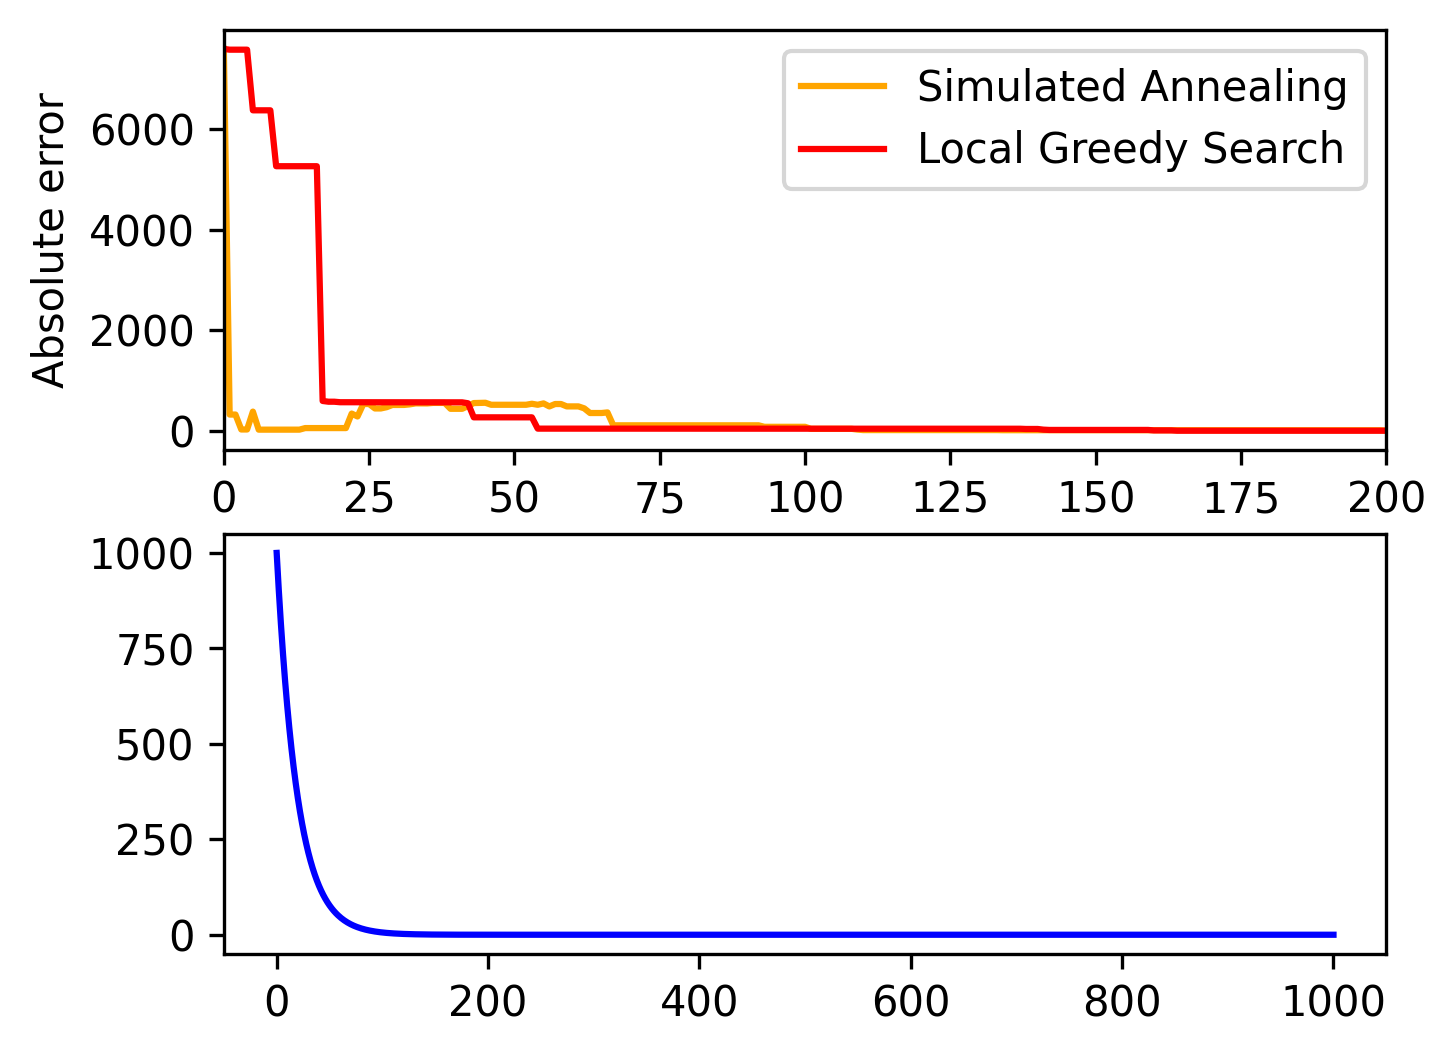

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4), dpi=300)
ax[0].plot(sa_F, color='orange', label='Simulated Annealing')
ax[1].plot(sa_Tv, color='blue', label='Temperature')
ax[0].plot(ls_F, color='red', label='Local Greedy Search')
ax[0].set_ylabel('Absolute error')
ax[0].set_xlabel('Iteration')
ax[0].set_xlim((0, 200))
ax[0].legend()
plt.show()

In [38]:
import time
import pandas as pd

# Función genérica para medir tiempo y ejecutar un algoritmo
def measure_execution_time(func, *args, **kwargs):
    start_time = time.time()
    results = func(*args, **kwargs)  # Ejecuta el algoritmo con los argumentos dados
    end_time = time.time()
    execution_time = end_time - start_time
    return results, execution_time

# Ejecutar y recolectar resultados para cada algoritmo
def run_algorithms(f, check_valid):
    results = []

    # Simulated Annealing
    for i in range(100):
        (sa_x, sa_f, sa_X, sa_V, sa_F, sa_Tv), sa_time = measure_execution_time(
            simulated_anealing, initial_op, f, check_valid, T0=500, alpha=0.90, max_iterations=max_iter, tol=tol
        )
        results.append({
            "Algoritmo": "Simulated Annealing",
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": sa_time,
            "Mejor solución": sa_x,
            "Mejor fitness": sa_f
        })

    # Genetic Algorithm
    for i in range(100):
        (ga_x, ga_f, ga_X, ga_V, ga_F), ga_time = measure_execution_time(
            genetic_algorithm, f, check_valid, population_size=100, max_generations=max_iter, mutation_rate=0.1, tol=tol
        )
        results.append({
            "Algoritmo": "Genetic Algorithm",
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": ga_time,
            "Mejor solución": ga_x,
            "Mejor fitness": ga_f
        })

    # Greedy Search
    for i in range(100):
        (ls_x, ls_f, ls_X, ls_V, ls_F), ls_time = measure_execution_time(
            greedy_search, initial_op, f, check_valid, max_iterations=1000, neighbour_sample=10, tol=0.01
        )
        results.append({
            "Algoritmo": "Greedy Search",
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": ls_time,
            "Mejor solución": ls_x,
            "Mejor fitness": ls_f
        })

    return results




In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Ejecutar los algoritmos y guardar los resultados en un DataFrame
results = run_algorithms(f2, check_valid2)
df = pd.DataFrame(results)

# Calcular promedios para cada algoritmo
summary = df.groupby("Algoritmo").agg({
    "Tiempo de ejecución (s)": "mean",
    "Mejor fitness": "min",
}).reset_index()

# Encontrar la mejor solución para cada algoritmo
best_solutions = df.loc[df.groupby("Algoritmo")["Mejor fitness"].idxmin(), ["Algoritmo", "Mejor solución"]]

# Combinar el resumen con las mejores soluciones
summary = pd.merge(summary, best_solutions, on="Algoritmo")

# Mostrar resultados completos
pd.set_option('display.max_colwidth', None)  # Asegurarse de que las columnas largas no se corten
print(df)  # Resultados individuales
print(summary)  # Resumen por algoritmo

df.to_csv('/content/drive/My Drive/resultados_con_restricciones_100.csv', index=False)# Exportar a Excel

Streaming output truncated to the last 5000 lines.
Iter: 210 | f: 0.105 | best_f: 0.105
Iter: 211 | f: 0.105 | best_f: 0.105
Iter: 212 | f: 0.105 | best_f: 0.105
Iter: 213 | f: 0.105 | best_f: 0.105
Iter: 214 | f: 0.105 | best_f: 0.105
Iter: 215 | f: 0.105 | best_f: 0.105
Iter: 216 | f: 0.105 | best_f: 0.105
Iter: 217 | f: 0.105 | best_f: 0.105
Iter: 218 | f: 0.105 | best_f: 0.105
Iter: 219 | f: 0.105 | best_f: 0.105
Iter: 220 | f: 0.105 | best_f: 0.105
Iter: 221 | f: 0.105 | best_f: 0.105
Iter: 222 | f: 0.105 | best_f: 0.105
Iter: 223 | f: 0.105 | best_f: 0.105
Iter: 224 | f: 0.105 | best_f: 0.105
Iter: 225 | f: 0.105 | best_f: 0.105
Iter: 226 | f: 0.105 | best_f: 0.105
Iter: 227 | f: 0.105 | best_f: 0.105
Iter: 228 | f: 0.105 | best_f: 0.105
Iter: 229 | f: 0.105 | best_f: 0.105
Iter: 230 | f: 0.105 | best_f: 0.105
Iter: 231 | f: 0.105 | best_f: 0.105
Iter: 232 | f: 0.105 | best_f: 0.105
Iter: 233 | f: 0.105 | best_f: 0.105
Iter: 234 | f: 0.105 | best_f: 0.105
Iter: 235 | f: 0.105 | b